In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb

In [3]:
!wandb login b032cc059132c9aac4f1b317f6f9ad007ef9e4d4

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Shivam Maurya/.netrc


In [4]:
wandb.init(project="CS6910_Assignment_1", name="Question:1")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs22m083. Use `wandb login --relogin` to force relogin


## Question 1 

In [5]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder

In [6]:
from matplotlib import pyplot as plt


In [7]:
from tensorflow.keras.datasets.fashion_mnist import load_data

In [8]:
from keras.datasets import fashion_mnist

In [9]:
#Load the fashion MNIST data 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [10]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

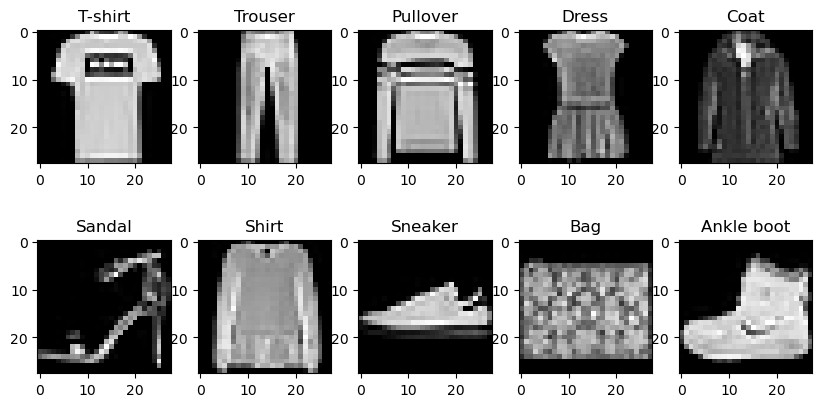

In [12]:
# Plot one sample image for each class
fig, ax = plt.subplots(2, 5, figsize=(10, 5)) #  returns a tuple containing a figure and axes object(s)
ax = ax.ravel()

for i in range(len(class_names)):
    ax[i].set_title(class_names[i])
    # Find the index of the first image with the current label
    idx = np.argmax(y_train == i) # Returns the indices of the maximum values along an axis.
    # Plotting the image
    ax[i].imshow(x_train[idx], cmap= 'gray') # display data as an image 
    wandb.log({"Question1": [wandb.Image(x_train[idx], caption= class_names[i])]})
plt.show()

In [13]:
wandb.finish()

## Question 2


In [14]:
class FFSN_MultiClass:
    def __init__(self, hidden_sizes=[3]):
        self.A = {}
        self.H = {}
        self.n_inputs = 0
        self.n_outputs= 0
        self.W = {}
        self.B = {}
        self.sizes = []
        self.hidden_size = hidden_sizes
        self.n_hidden = len(hidden_sizes)
        
    # Function to initialize the weights between the layers of the network. Weights are initialized randomly.             
    def weights_init(self):
        
        np.random.seed(120)
        np.random.RandomState(120)
        self.sizes = [self.n_inputs] + self.hidden_size + [self.n_outputs]
        for i in range(self.n_hidden + 1):
            size = self.sizes[i+1]
            self.B[i+1] = np.zeros((1, size))# Zero initialization of Biases as matrix of size of 1 * next layer.
            self.W[i+1] = np.random.randn(self.sizes[i], size) # Random initialization of weights per layer.
            


    def forward_pass(self, x, act_fun):
        
        self.H[0] = x.reshape(1, -1)
        
        for i in range(self.n_hidden):
            bias = self.B[i+1]
            weight = self.W[i+1]
            self.A[i+1] = np.matmul(self.H[i], weight) + bias
            self.H[i+1] = self.activation_fun( act_fun,  self.A[i+1] )
            
        self.A[self.n_hidden+1] = np.matmul(self.H[self.n_hidden], self.W[self.n_hidden+1]) + self.B[self.n_hidden+1]
        self.H[self.n_hidden+1] = self.softmax(self.A[self.n_hidden+1])
        return self.H[self.n_hidden+1]
    
    def predict(self, X, act_fun):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x, act_fun)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation_fun(self, fun, X):
        
        if fun == "tanh":
            return self.tanh(X)
        elif fun == "relu":
            return self.relu(X)
        else:
            return self.sigmoid(X);
        
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        y = (x > 0)
        return X * y
        
    
    #Sigmoid Function
    def sigmoid(self, x):
        
        return (1./(1.0 + np.exp(-x)))


    def fit(self, act_fun, X, Y):
        ny = Y.shape[1]
        self.n_inputs = X.shape[1] * X.shape[1]
        self.n_outputs = ny
        self.weights_init()
        
        
        return self.predict(X, act_fun)

In [15]:
enc = OneHotEncoder()
x_train = x_train/255.0
x_test = x_test/255.0
y_OH_test = enc.fit_transform(np.expand_dims(y_test, 1)).toarray()
y_OH_train = enc.fit_transform(np.expand_dims(y_train, 1)).toarray()
print(y_OH_train.shape, y_OH_test.shape)
print(x_train.shape)

(60000, 10) (10000, 10)
(60000, 28, 28)


In [16]:
obj = FFSN_MultiClass([150, 260, 380])
activation_name = "sigmoid"
clas_pred = obj.fit(activation_name, x_train, y_OH_train)

In [17]:
np.set_printoptions(suppress=True)

In [18]:
 print(clas_pred[50])

[0.00024276 0.0001071  0.         0.         0.00000016 0.98679121
 0.00390697 0.00005168 0.00000237 0.00889774]


In [19]:
print(y_OH_train[50])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Question 3

In [20]:
class FFNN():
 
    def __init__(self,opt, hidden_sizes, loss_fun, activation_fun, output_act, b_s= 1024, epochs = 10, initialization = "Random", log=0, train_losses = None, train_accuracy = None, test_losses = None, test_accuracy = None):
        
        self.train_accuracy_list = train_accuracy
        self.batch_size = b_s
        self.layer_sizes = []
        self.output_activation = output_act
        self.dw = {}
        self.output_layer_size=1
        self.input_layer_size=0
        self.A = {}
        self.hidden_layer_sizes = hidden_sizes
        self.dH = {}
        self.loss_function = loss_fun
        self.H = {}
        self.train_losses_list = train_losses
        self.optimizer = opt
        self.dA = {}
        self.activation_function = activation_fun
        self.weights = {}
        self.db = {}
        self.biases = {}
        #Layer sizes array will be initialzed after input and output layer size is obtained
        self.val_accuracy_list = test_accuracy
        self.val_losses_list = test_losses
        self.wan_log = log
        self.epochs = epochs
        self.initialization = initialization


    def initialize_weights(self):
      
        #Function to initialize the weights between the layers of the network. Weights are initialized randomly.
        self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
        np.random.seed(137)
        np.random.RandomState(137)
        ln = len(self.hidden_layer_sizes)
        self.optimizer.initialize(self.layer_sizes)
        weight_counts =ln  +1
        for i in range(weight_counts):
            
            s_size = (self.layer_sizes[i], self.layer_sizes[i+1])
            lsize_i = self.layer_sizes[i]
            lsize_i1 = self.layer_sizes[i+1]
        
            if self.initialization == "Xavier":
               
                self.weights[i+1] = np.random.normal(0.0, np.sqrt(2 / float(lsize_i + lsize_i1)) , size = s_size)

            elif self.initialization == "Random":
               
                self.weights[i+1] = np.random.randn(lsize_i, lsize_i1)
            self.biases[i+1] = np.zeros((1, lsize_i1))


    def forward_propogation(self, X):
        
        ln = len(self.hidden_layer_sizes)
        
        self.H = {}
        #Initialize the output from input layer as H[0] into a single row(row vector)
        self.H[0] = X.reshape(1,-1)
        self.A = {}
        #Compute a(x) = W_x*h(x-1) and h(a(x)) = activation(a(x)) for hidden layer
        for i in range(ln):
            weight = self.weights[i+1]
            bias = self.biases[i+1]
            self.A[i+1] = np.matmul(self.H[i], weight) + bias
            self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

        ln = ln +1
        weight = self.weights[ln]
        bias = self.biases[ln]
        self.A[ln] = np.matmul(self.H[ln-1], weight) + bias
        #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
        self.H[ln] = self.output_activation.compute_activation(self.A[ln]) 
        return  self.H[ln]

    def backward_propogation(self, X, Y,  dw_i, db_i):
        
        ln = len(self.hidden_layer_sizes)
        #Compute the gradient of loss wrt the activation of output layer
        self.dA[ln +1] = self.loss_function.last_output_derivative(self.H[ln +1], Y, self.output_activation.compute_derivative(self.A[ln +1]))

        #Compute the partial derivatives for the weights and biases of the layers
        # change in weight : (assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
        # change in biase : (assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
        for i in range(ln, -1, -1):
            weight = self.weights[i+1].T
            db_i[i+1] = self.dA[i+1]
            dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
            
            if i!=0:
                self.dH[i] = np.matmul(self.dA[i+1],weight)  
                act_grad = self.activation_function.compute_derivative(self.A[i])
                self.dA[i] = np.multiply(act_grad, self.dH[i])    
               
        return dw_i, db_i


    def fit(self, X, Y, X_val, Y_val, console = 1):
        
        #Function to fit the data (X,Y) on the model. This performs forward + backward pass for epoch number of times. Gradient is updated after each batch is processed.
        self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
        self.console_log = console
        self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
        hidden_ls = self.hidden_layer_sizes
        self.initialize_weights()
        ln = len(self.hidden_layer_sizes)+1
        for e in range(self.epochs):
            count = -1
            for i in range(ln):
                layer_size = self.layer_sizes[i+1]
                self.db[i+1] = np.zeros((1, layer_size))
                self.dw[i+1] = np.zeros((self.layer_sizes[i], layer_size))
                
            y_preds = []

            for x, y in zip(X, Y):
                count += 1
                db_i = {}
                dw_i = {}

                if count==self.batch_size:
                    #Done wih current batch
        
                    if self.optimizer.optimizer_name()=="nag":
                        b_lookahead = {}
                        w_lookahead = {}
                        
                        for i in range(ln):
                            b_upd = self.optimizer.gamma*self.optimizer.update_history_b[i+1]
                            w_upd = self.optimizer.gamma*self.optimizer.update_history_w[i+1]
                            b_lookahead[i+1] = self.biases[i+1] - b_upd
                            w_lookahead[i+1] = self.weights[i+1] - w_upd
                            
                        
                        weights_old = self.weights
                        self.weights = w_lookahead
                        self.forward_propogation(x)
                        dw_lookahead, db_lookahead = self.backward_propogation(x,y, dw_i, db_i) 
                        self.biases = b_lookahead
                        biases_old = self.biases
                        self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, hidden_ls)

                    else: 
                        self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, hidden_ls)
                    
                    for i in range(ln):
                        lsize1 = self.layer_sizes[i+1]
                        lsize = self.layer_sizes[i]
                        self.db[i+1] = np.zeros((1, lsize1))
                        self.dw[i+1] = np.zeros((lsize, lsize1))

                    count = 0
                #Forward Propogation
                self.forward_propogation(x)

                #Predictions
                y_preds.append(self.H[ln])

                #Backward Propogation using Loss funtion
                self.backward_propogation(x,y, dw_i, db_i) 

                for i in range(ln):
                    b_i = db_i[i+1]
                    w_i = dw_i[i+1]
                    self.db[i+1] = self.db[i+1] + b_i
                    self.dw[i+1] = self.dw[i+1] + w_i
                    
           
            #Update weights based on loss(GD hence once every epoch update)
            if self.optimizer.optimizer_name()=="nag":
                b_lookahead = {}
                w_lookahead = {}
                
                for i in range(ln):
                    bias = self.biases[i+1]
                    weight = self.weights[i+1]
                    b_upd = self.optimizer.gamma*self.optimizer.update_history_b[i+1]
                    w_upd = self.optimizer.gamma*self.optimizer.update_history_w[i+1]
                    b_lookahead[i+1] = bias - b_upd
                    w_lookahead[i+1] = weight - w_upd     
                
                biases_old, weights_old= self.biases, self.weights
                self.biases, self.weights = b_lookahead , w_lookahead
                
                self.forward_propogation(x)
                dw_lookahead, db_lookahead = self.backward_propogation(x, y, dw_i, db_i) 
                self.weights, self.biases = self.optimizer.update_parameters(weights_old, biases_old, dw_lookahead, db_lookahead, hidden_ls)

            else:  
                self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, hidden_ls)
            
            y_preds = np.array(y_preds).squeeze()
            y_preds_validation = self.predict(X_val)
            
            validation_loss = self.loss_function.compute_loss(Y_val, y_preds_validation, self.batch_size)
            if self.val_losses_list != None:
                self.val_losses_list.append(validation_loss) 
            
            training_loss = self.loss_function.compute_loss(Y, y_preds, self.batch_size)
            if self.train_losses_list != None:
                self.train_losses_list.append(training_loss)
                
            validation_accuracy = accuracy_score(np.argmax(Y_val,1), np.argmax(y_preds_validation,1))
            if self.val_accuracy_list != None:
                self.val_accuracy_list.append(validation_accuracy)
                
            training_accuracy = accuracy_score(np.argmax(Y,1), np.argmax(y_preds,1))
            if self.train_accuracy_list != None:
                self.train_accuracy_list.append(training_accuracy)
           
              
            if self.console_log == 1: #For Printing Log results on Console 
                print("Training Loss: ",round(training_loss,3),"Val_loss:", round(validation_loss, 3), " Training Accuracy: ",round(training_accuracy,3), "Val_accuracy:", round(validation_accuracy,3), " <-:Epoch:",e+1,)
            
            
            elif self.wan_log==1:#For Log metrics on wandb
                
                wandb.log({"Training_accuracy": training_accuracy, "Validation_accuracy": validation_accuracy, "Training_loss": training_loss, "Validation_loss": validation_loss, 'Epoch': e+1})

    
        return training_loss, validation_loss, training_accuracy, validation_accuracy

    def predict(self, X):
        y_pred = []
        for x in X:
            pred = self.forward_propogation(x)
            y_pred.append(pred)

        y_pred = np.array(y_pred).squeeze()
        return y_pred

## Optimization Function

In [21]:
class Optimizer():
    
    def __init__(self, optimizer,  learning_rate = 0.001,  gamma = 0.001, beta1 = 0.9, beta2 = 0.999, weight_decay = 0.0, epsilon = 1e-8):
        
        self.update_history_b = {}
        self.m_b = {}
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.db_look_ahead = {}
        self.b_look_ahead = {}
        self.weight_decay = weight_decay
        self.v_b = {}
        self.dw_look_ahead ={}
        self.gamma = gamma
        self.w_look_ahead = {}
        self.update_history_w = {}
        self.lr =0
        self.epsilon = epsilon
        self.m_w = {}
        self.v_w ={}
        if( self.optimizer == "sgd"):
            self.learning_rate = learning_rate
            self.weight_decay = weight_decay
            
        if( self.optimizer == "momentum" ):
            self.weight_decay = weight_decay
            self.initialized = False
            self.update_history_w = {}
            self.learning_rate = learning_rate
            self.update_history_b = {}
            self.gamma = gamma
        
        if( self.optimizer == "nag"):
            self.initialized = False
            self.update_history_b = {}
            self.update_history_w = {}
            self.learning_rate = learning_rate
            self.b_look_ahead={}
            self.w_look_ahead={}
            self.gamma = gamma
            self.db_look_ahead={}
            self.dw_look_ahead={}

        if( self.optimizer == "rmsprop"):
            self.initialized = False
            self.weight_decay = weight_decay
            self.v_b = {}
            self.v_w = {}
            self.epsilon = epsilon
            self.gamma = gamma
            self.learning_rate = learning_rate
            
            

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.initialized = False
            self.epsilon = epsilon
            self.v_b = {}
            self.v_w = {}
            self.beta1 = beta1
            self.beta2 = beta2
            self.m_b = {}
            self.m_w = {}
            self.iterations = 1
            self.learning_rate = learning_rate
            self.weight_decay = weight_decay
        

    def set_learning_rate(self, learning_rate):

        if(self.optimizer == "sgd"):
            self.learning_rate = learning_rate

        if( self.optimizer == "momentum" ):
            self.learning_rate = learning_rate
        
        if( self.optimizer == "nag"):
            self.learning_rate = learning_rate

        if( self.optimizer == "rmsprop"):
            self.learning_rate = learning_rate

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.learning_rate = learning_rate



    def set_weight_decay(self, weight_dec):
        self.weight_decay = weight_dec
        
    def set_initial_parameters(self, parameters):
        
        if(self.optimizer == "sgd"):
            self.weight_decay = parameters["weight_decay"]
            self.learning_rate = parameters["learning_rate"]

        if( self.optimizer == "momentum" ):
            self.weight_decay = parameters["weight_decay"]
            self.gamma = parameters["gamma"]
            self.learning_rate = parameters["learning_rate"]
            
        
        if( self.optimizer == "nag"):
            self.gamma = parameters["gamma"]
            self.learning_rate = parameters["learning_rate"]

        if( self.optimizer == "rmsprop"):
            
            self.weight_decay = parameters["weight_decay"]
            self.learning_rate = parameters["learning_rate"]
            self.lr = 0.01
            self.epsilon = parameters["epsilon"]
            self.gamma = parameters["gamma"]
            

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            self.weight_decay = parameters["weight_decay"]
            self.lr = 0.01
            self.epsilon = parameters["epsilon"]
            self.beta1, self.beta2  = parameters["beta1"], parameters["beta2"]
            self.learning_rate = parameters["learning_rate"]
            
    def initialize(self, all_layers):
        
        self.b_look_ahead.clear()
        self.update_history_b.clear()
        ln = len(all_layers)
        self.m_b.clear()
        self.dw_look_ahead.clear()
        self.v_b.clear()
        self.w_look_ahead.clear()
        ln = ln -1
        self.update_history_w.clear()
        self.m_w.clear()
        self.db_look_ahead.clear()
        self.v_w.clear()
        
        if(self.optimizer == "sgd"):
            return

        if( self.optimizer == "momentum" ):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.update_history_b[i+1] = np.zeros((1, all_layer))
                self.update_history_w[i+1] = np.zeros((all_layers[i], all_layer))
                
        if( self.optimizer == "nag"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.update_history_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.dw_look_ahead[i+1] = np.zeros((all_layers[i], all_layer))
                self.w_look_ahead[i+1] = np.zeros((all_layers[i], all_layer))
                self.update_history_b[i+1] = np.zeros((1, all_layer))
                self.db_look_ahead[i+1] = np.zeros((1, all_layer))
                self.b_look_ahead[i+1] = np.zeros((1, all_layer))

        if( self.optimizer == "rmsprop"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.v_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.v_b[i+1] = np.zeros((1, all_layer))

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            
            for i in range(ln):
                all_layer = all_layers[i+1]
                self.m_b[i+1] = np.zeros((1, all_layer))
                self.v_b[i+1] = np.zeros((1, all_layer))
                self.m_w[i+1] = np.zeros((all_layers[i], all_layer))
                self.v_w[i+1] = np.zeros((all_layers[i], all_layer))
                
    def optimizer_name(self):

        if(self.optimizer == "sgd"):
            return "sgd"

        if( self.optimizer == "momentum" ):
            return "momentum"
        
        if( self.optimizer == "nag"):
            return "nag"

        if( self.optimizer == "rmsprop"):
            return "rmsprop"

        if( self.optimizer == "adam"):
            return "adam"
        if( self.optimizer == "nadam"):
            return "nadam"

    def update_parameters(self, weights, biases, dw, db, layers):
        nlayer = len(layers)+1
        if(self.optimizer == "sgd"):
            for i in range(nlayer):
                decay_wt = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + decay_wt
                grad_b = self.learning_rate * db[i+1]
                grad_w = self.learning_rate * dw[i+1]
                biases[i+1] = biases[i+1] - grad_b # b_t = b_{t-1} - eta*(dL/db)
                weights[i+1] = weights[i+1] - grad_w # w_t = w_{t-1} - eta*(dL/dw)
            
            return weights, biases

        if( self.optimizer == "momentum" ):
            """
            Function to perform the weight update step based on optimizer algorithm
            """

            for i in range(nlayer):
                
                wt_decay = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + wt_decay
                upd_bias = self.learning_rate*db[i+1]
                upd_weight = self.learning_rate*dw[i+1]
                self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + upd_bias 
                self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + upd_weight
                biases[i+1] = biases[i+1] - self.update_history_b[i+1]
                weights[i+1] = weights[i+1] - self.update_history_w[i+1]
            
            return weights, biases
        
        if( self.optimizer == "nag"):
            """
            Function to perform the weight update step based on optimizer algorithm
            """
            for i in range(nlayer):
                
                grad_db = self.learning_rate*db[i+1]
                grad_dw = self.learning_rate*dw[i+1]
                self.update_history_b[i+1] = self.gamma*self.update_history_b[i+1] 
                self.update_history_b[i+1] += grad_db
                biases[i+1] = biases[i+1] - self.update_history_b[i+1]
                self.update_history_w[i+1] = self.gamma*self.update_history_w[i+1] 
                self.update_history_w[i+1] += grad_dw
                weights[i+1] = weights[i+1] - self.update_history_w[i+1]
                

            return weights, biases

        if( self.optimizer == "rmsprop"):
            for i in range(nlayer):
                eps = self.epsilon
                lr = self.learning_rate
                wt_decay = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + wt_decay
                
                v_weight = self.gamma*self.v_w[i+1] 
                self.v_w[i+1] = v_weight + (1-self.gamma)* ((dw[i+1])**2)
                
                v_bias = self.gamma*self.v_b[i+1]
                self.v_b[i+1] = v_bias + (1-self.gamma)* ((db[i+1])**2)
                
                biase_upd = ((lr)/np.sqrt(self.v_b[i+1] + eps))*db[i+1]
                weight_upd = ((lr)/np.sqrt(self.v_w[i+1] + eps))*dw[i+1]

                biases[i+1] = biases[i+1] - biase_upd
                weights[i+1] = weights[i+1] - weight_upd
            
            return weights, biases

        if( self.optimizer == "adam" or self.optimizer == "nadam"):
            #Function to perform the weight update step based on optimizer algorithm
           
            for i in range(nlayer):
                eps = self.epsilon
                lr = self.learning_rate
                upd_wt = self.weight_decay*weights[i+1]
                dw[i+1] = dw[i+1] + upd_wt

                m_bias = self.beta1*self.m_b[i+1] 
                self.m_b[i+1] = m_bias + (1-self.beta1)* (db[i+1])
                m_weight = self.beta1*self.m_w[i+1] 
                self.m_w[i+1] = m_weight + (1-self.beta1)* (dw[i+1])
                v_weight = self.beta2*self.v_w[i+1] 
                self.v_w[i+1] = v_weight + (1-self.beta2)* ((dw[i+1])**2)
                v_bias = self.beta2*self.v_b[i+1] 
                self.v_b[i+1] = v_bias + (1-self.beta2)* ((db[i+1])**2)
                
                v_hat_div = (1-(self.beta2**self.iterations))
                m_hat_div = (1-(self.beta1**self.iterations))
                v_b_hat = self.v_b[i+1] / v_hat_div
                m_b_hat = self.m_b[i+1] / m_hat_div
                v_w_hat = self.v_w[i+1] / v_hat_div
                m_w_hat = self.m_w[i+1] / m_hat_div
                
                if(self.optimizer == "nadam"):
                    
                    weight_upd = ((lr)/(np.sqrt(v_w_hat) + eps))*(self.beta1 * m_w_hat + (nadam_impl * dw[i+1]))
                    weights[i+1] = weights[i+1] - weight_upd
                    biases_upd = ((lr)/(np.sqrt(v_b_hat) + eps))*(self.beta1 * m_b_hat + (nadam_impl * db[i+1]))
                    biases[i+1] = biases[i+1] - biases_upd
                elif(self.optimizer == "adam"):
                    weights_upd = ((lr)/(np.sqrt(v_w_hat) + eps))*(m_w_hat)
                    biases_upd = ((lr)/(np.sqrt(v_b_hat) + eps))*(m_b_hat)
                    
                    weights[i+1] = weights[i+1] - weights_upd
                    biases[i+1] = biases[i+1] - biases_upd
                
                nadam_impl = (1-self.beta1)/(1-(self.beta1**self.iterations))
                
            self.iterations = self.iterations + 1
            
            return weights, biases


## Activation Function

In [22]:
class ActivationFunction():
    def __init__(self, fun = "sigmoid"):
        self.act_fun = fun

    def compute_activation(self, X):

        if(self.act_fun == "sigmoid"):
            return 1.0/(1.0+np.exp(-X)) # sigmoid function
        if(self.act_fun == "softmax"):
            exponentials = np.exp(X) # softmax function
            return exponentials / np.sum(exponentials)
        if(self.act_fun == "tanh"):
            return np.tanh(X) # tanh function
        if(self.act_fun == "relu"):
            return X * (X > 0) # relu function
            
    def compute_derivative(self, X):
        if(self.act_fun == "sigmoid"):
            val = self.compute_activation(X)
            return val*(1-val)
        if(self.act_fun == "softmax"):
            softmax = self.compute_activation(X)
            return softmax*(1-softmax)
        if(self.act_fun == "tanh"):
            return 1 - (np.tanh(X) ** 2)
        if(self.act_fun == "relu"): 
            X[X > 0.0] = 1.0
            X[X <= 0.0] = 0.0
            return X

## Loss Function

In [23]:
class LossFunction():
    def __init__(self, fun = "cross_entropy"):
        self.loss_fun = fun
    
    def compute_loss(self, Y_true, Y_pred, batch_size):
        ln = len(Y_true)
        lss = 0
        if(self.loss_fun == "squared_loss"):
            return (1/2) * np.sum((Y_pred-Y_true)**2) / ln
        
        if(self.loss_fun == "cross_entropy"):
            for p in Y_pred[0]:
                if p < 10e-8  or np.isnan(p):
                    p = 10e-8
                    lss += 1
            loss = np.multiply(Y_pred,Y_true)
            loss = loss[loss != 0]
            lss  = loss
            loss = -np.log(loss)
            loss = np.mean(loss)
            return loss

    def name(self):
        if(self.loss_fun == "squared_loss"):
            return "squared_loss" 
        
        if(self.loss_fun == "cross_entropy"):
            return "cross_entropy_loss"

    def compute_derivative(self, Y_pred,Y_true):
        
        if(self.loss_fun == "squared_loss"):
            return (Y_pred)*(Y_pred-Y_true)/len(Y_true)
        
        if(self.loss_fun == "cross_entropy"):
            return -Y_true/(Y_pred)
            

    def last_output_derivative(self, Y_pred,Y_true,activation_derivative):
        ln = len(Y_true)
        lss = 0
        for p in Y_pred[0]:
                if (np.isnan(p) or p < 10e-8):
                    lss += 1
                    p = 10e-8
        if(self.loss_fun == "squared_loss"):
            return (Y_pred - Y_true)*activation_derivative / ln
        
        if(self.loss_fun == "cross_entropy"):
            return -(Y_true - Y_pred)

## Testing Model

In [24]:
# Parameters Selection for Different Optimization Algorithm
parameters_sgd = {"learning_rate":0.001, "weight_decay":0.5} #sgd
parameters_momentum = {"learning_rate":0.0001, "gamma":0.6, "weight_decay":0} #momentum
parameters_nag = {"learning_rate":0.001, "gamma":0.009} #nag
parameters_rmsprop = {"learning_rate":0.01, "gamma":0.009, "epsilon":1e-8, "weight_decay":0.5} #rmsprop
parameters_adam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #adam
parameters_nadam = {"learning_rate":0.0006, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":0.001} #nadam


# "sgd" : gradient_descent, "momentum" : momentum_gd, "nag": nag , "rmsprop":  RMSProp, "adam": Adam "nadam": Nadam

optimizer = Optimizer("adam")
optimizer.set_initial_parameters(parameters_adam)


#  "cross_entropy" : Cross Entropy Loss Function,  "squared_loss" : Squared Error Loss Function
loss_fun = LossFunction("cross_entropy")

#Select activation-function(hidden layers) pass below respective string to select any Activation Fuction Eg:"tanh" in ActivationFunction
# "sigmoid": SigmoidFunction, "softmax": SoftmaxFunction, "tanh": TanhFunction, "relu":ReLUFunction
act_fun_hidden = ActivationFunction("tanh")

#Select activation - function for output layer
act_fun_output = ActivationFunction("softmax")

#Add layer sizes for the hidden layers
layers = [32, 64, 128]

model = FFNN(optimizer, layers, loss_fun, act_fun_hidden, act_fun_output, 64, 10, initialization = "Xavier")
train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test)


Training Loss:  0.559 Val_loss: 0.455  Training Accuracy:  0.799 Val_accuracy: 0.835  <-:Epoch: 1
Training Loss:  0.401 Val_loss: 0.416  Training Accuracy:  0.854 Val_accuracy: 0.848  <-:Epoch: 2
Training Loss:  0.366 Val_loss: 0.399  Training Accuracy:  0.866 Val_accuracy: 0.855  <-:Epoch: 3
Training Loss:  0.344 Val_loss: 0.388  Training Accuracy:  0.874 Val_accuracy: 0.858  <-:Epoch: 4
Training Loss:  0.328 Val_loss: 0.38  Training Accuracy:  0.88 Val_accuracy: 0.863  <-:Epoch: 5
Training Loss:  0.315 Val_loss: 0.373  Training Accuracy:  0.884 Val_accuracy: 0.866  <-:Epoch: 6
Training Loss:  0.304 Val_loss: 0.369  Training Accuracy:  0.888 Val_accuracy: 0.867  <-:Epoch: 7
Training Loss:  0.294 Val_loss: 0.365  Training Accuracy:  0.891 Val_accuracy: 0.868  <-:Epoch: 8
Training Loss:  0.285 Val_loss: 0.363  Training Accuracy:  0.894 Val_accuracy: 0.87  <-:Epoch: 9
Training Loss:  0.277 Val_loss: 0.363  Training Accuracy:  0.897 Val_accuracy: 0.87  <-:Epoch: 10


In [25]:
#Accuracy for test data
y_preds = model.predict(x_test)
accuracy_train = accuracy_score(np.argmax(y_OH_test,1), np.argmax(y_preds,1))
print("Training accuracy", round(accuracy_train, 3))
print("Validation Loss:", round(val_loss,3), "Validation Accuracy:", round(val_accuracy,3))

Training accuracy 0.87
Validation Loss: 0.363 Validation Accuracy: 0.87


## Question 4

In [26]:
sweep_config = {
    #RandomSearch over the hyperparameters
    'method': 'random',
    'metric': { 'goal': 'maximize','name': 'accuracy'},
    
    'parameters': {'activation': {'values': ['sigmoid' , 'tanh', 'relu']},
                
                    'batch_size':{'values':[16,32,64]},
                    'optimizer': {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']},
                    'hidden_layers': {'values': [ [32,64],[32,64,128],[32,64,128,256]]},
                    'epochs': {'values': [5,10]},
                    'weight_decay': {'values': [0.0, 0.0005, 0.5]},
                    'gamma': {'values': [0.03, 0.0006, 0.002]},
                    'learning_rate': {'values': [0.0001, 0.005, 0.0006, 0.01, 0.0003, 0.0005]},
                    'initialization':{'values': ['Xavier', 'Random']}
                  }
               }

In [27]:
def train():

    var1 = wandb.init(project="CS6910_Assignment_1", name="Question:4")
    var2 = var1.config

    # var2 is a variable that holds and saves hyperparameters and inputs
    wandb.run.name = 'optimizer:-' + var2.optimizer + ' epochs:-' + str(var2.epochs) + ' activation:-' + var2.activation + ' init:-' + var2.initialization + ' layers:-' + str(len(var2.hidden_layers)) +' decay:-' + str(var2.weight_decay) + ' gamma:-' + str(var2.gamma) + ' learning_rate:-' + str(var2.learning_rate) + ' batch_size:-' + str(var2.batch_size)

    
    loss_fun = LossFunction("cross_entropy")
    epochs = var2.epochs
    weight_decay = var2.weight_decay
    hidden_layers = var2.hidden_layers
    gamma = var2.gamma
    learning_rate = var2.learning_rate

    if var2.activation=="sigmoid":
        activation = ActivationFunction("sigmoid")
    if var2.activation=="tanh":
        activation = ActivationFunction("tanh")
    if var2.activation=="relu":
        activation = ActivationFunction("relu")

    output_activation = ActivationFunction("softmax")


    parameters_sgd = {"learning_rate": learning_rate, "weight_decay":weight_decay}
    parameters_momentum = {"learning_rate": learning_rate, "gamma": gamma, "weight_decay":weight_decay}
    parameters_nag = {"learning_rate": learning_rate, "gamma": gamma}
    parameters_rmsprop = {"learning_rate": learning_rate, "gamma":gamma, "epsilon":1e-8, "weight_decay":weight_decay}
    parameters_adam = {"learning_rate": learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}
    parameters_nadam = {"learning_rate": learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8, "weight_decay":weight_decay}

    if var2.optimizer=="sgd":
        optimizer = Optimizer("sgd")
        optimizer.set_initial_parameters(parameters_sgd)

    if var2.optimizer=="momentum":
        #Select optimizer(momentum)
        optimizer = Optimizer("momentum")
        optimizer.set_initial_parameters(parameters_momentum)

    if var2.optimizer=="nag":
        #Select optimizer(momentum)
        optimizer = Optimizer("nag")
        optimizer.set_initial_parameters(parameters_nag)

    if var2.optimizer=="rmsprop":
        #Select optimizer(rmsprop)
        optimizer = Optimizer("rmsprop")
        optimizer.set_initial_parameters(parameters_rmsprop)

    if var2.optimizer=="adam":
        #Select optimizer(adam)
        optimizer = Optimizer("adam")
        optimizer.set_initial_parameters(parameters_adam)

    if var2.optimizer=="nadam":
        #Select optimizer(nadam)
        optimizer = Optimizer("nadam")
        optimizer.set_initial_parameters(parameters_nadam)

    if(var2.initialization == "Random"):
        initn = "Random"
    else:
        initn = "Xavier"
    
    batch_size = var2.batch_size

    #Model training 
    #Ensure that log=1 parameter is set for logging onto wandb
    model = FFNN(optimizer, hidden_layers, loss_fun, activation, output_activation, batch_size, epochs, initn, log=1)

    train_loss, val_loss, train_accuracy, val_accuracy = model.fit(x_train, y_OH_train, x_test, y_OH_test, console= 0)
    print(" Training Loss: ",train_loss, " Validation Loss:",val_loss ," Training Accuracy: ",train_accuracy, " Validation Accuracy:", val_accuracy)

    #Log validation accuracy for this run
    wandb.log({"Accuracy": val_accuracy})

In [28]:
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment_1")

Create sweep with ID: cezmcy51
Sweep URL: https://wandb.ai/cs22m083/CS6910_Assignment_1/sweeps/cezmcy51


In [29]:
wandb.agent(sweep_id, train, count = 60)

wandb: Agent Starting Run: sj6dy16w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.39661467813921125  Validation Loss: 0.46765179867394874  Training Accuracy:  0.85935  Validation Accuracy: 0.8433


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇████
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▇▇▇▇█▇██
Validation_loss,█▄▂▃▁▂▁▂▁▁
Accuracy,0.8433
Epoch,10
Training_accuracy,0.85935
Training_loss,0.39661
Validation_accuracy,0.8433


wandb: Agent Starting Run: gqs15yyz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.48819665589748645  Validation Loss: 0.5078990443179041  Training Accuracy:  0.8338666666666666  Validation Accuracy: 0.827


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇████
Training_loss,█▄▃▂▂▂▂▁▁▁
Validation_accuracy,▂▁▄▇▆▅█▇▇█
Validation_loss,██▅▃▃▅▂▃▂▁
Accuracy,0.827
Epoch,10
Training_accuracy,0.83387
Training_loss,0.4882
Validation_accuracy,0.827


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zckg9bk8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3481033596036321  Validation Loss: 0.3971345538448674  Training Accuracy:  0.8716833333333334  Validation Accuracy: 0.8544


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▇▇█
Validation_loss,█▅▂▂▁
Accuracy,0.8544
Epoch,5
Training_accuracy,0.87168
Training_loss,0.3481
Validation_accuracy,0.8544


wandb: Agent Starting Run: ye4u40i2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.1895461612560456  Validation Loss: 1.194681937708019  Training Accuracy:  0.58155  Validation Accuracy: 0.5773


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▅▆▇▇████
Training_loss,█▃▂▂▁▁▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▅▄▃▂▂▂▁▁▁
Accuracy,0.5773
Epoch,10
Training_accuracy,0.58155
Training_loss,1.18955
Validation_accuracy,0.5773


wandb: Agent Starting Run: guol6lz3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run guol6lz3 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run guol6lz3 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: u5w3rxx7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0247837171737908  Validation Loss: 0.9955189058130387  Training Accuracy:  0.6320666666666667  Validation Accuracy: 0.6342


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▂▂▄▅▆▇███
Training_loss,██▇▇▆▄▃▂▂▁
Validation_accuracy,▁▁▃▄▆▇▇███
Validation_loss,██▇▆▅▄▃▂▁▁
Accuracy,0.6342
Epoch,10
Training_accuracy,0.63207
Training_loss,1.02478
Validation_accuracy,0.6342


wandb: Agent Starting Run: c4gv90fw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.47152537424245444  Validation Loss: 0.5084395029914472  Training Accuracy:  0.8305833333333333  Validation Accuracy: 0.8202


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▆██
Validation_loss,█▅▃▂▁
Accuracy,0.8202
Epoch,5
Training_accuracy,0.83058
Training_loss,0.47153
Validation_accuracy,0.8202


wandb: Agent Starting Run: ih4bn9x7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run ih4bn9x7 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run ih4bn9x7 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: ilo7aniq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run ilo7aniq errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run ilo7aniq errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: rxao2a91 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.298169046258796  Validation Loss: 2.2956454615022923  Training Accuracy:  0.11866666666666667  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▃▅▆█
Training_loss,█▃▃▂▁
Validation_accuracy,▁▁▁▁▁
Validation_loss,█▆▅▃▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.11867
Training_loss,2.29817
Validation_accuracy,0.1


wandb: Agent Starting Run: o747ohz6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5589338039166702  Validation Loss: 0.6000648601893317  Training Accuracy:  0.8331  Validation Accuracy: 0.824


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▇▇██
Training_loss,█▂▁▁▁
Validation_accuracy,▁▆▇▇█
Validation_loss,█▃▂▂▁
Accuracy,0.824
Epoch,5
Training_accuracy,0.8331
Training_loss,0.55893
Validation_accuracy,0.824


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uew3s917 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run uew3s917 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run uew3s917 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: y38lh9jd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.681808374778824  Validation Loss: 0.7065978658867267  Training Accuracy:  0.7652333333333333  Validation Accuracy: 0.7614


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▇███
Training_loss,█▁▁▁▁
Validation_accuracy,▁█▆▄▄
Validation_loss,█▁▂▃▂
Accuracy,0.7614
Epoch,5
Training_accuracy,0.76523
Training_loss,0.68181
Validation_accuracy,0.7614


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uv7v6lj4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4647485894241407  Validation Loss: 0.5178245448560398  Training Accuracy:  0.84645  Validation Accuracy: 0.8363


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▅██
Validation_loss,█▆▄▁▂
Accuracy,0.8363
Epoch,5
Training_accuracy,0.84645
Training_loss,0.46475
Validation_accuracy,0.8363


wandb: Agent Starting Run: nwqsnivc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3709904071463237  Validation Loss: 0.4050658145820652  Training Accuracy:  0.8662  Validation Accuracy: 0.8538


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▅▃▂▁
Accuracy,0.8538
Epoch,5
Training_accuracy,0.8662
Training_loss,0.37099
Validation_accuracy,0.8538


wandb: Agent Starting Run: oukaqp58 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.7140765409756828  Validation Loss: 1.9444745864792197  Training Accuracy:  0.7181166666666666  Validation Accuracy: 0.7306


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▃▇▁▄█
Training_loss,▁▂█▃▁
Validation_accuracy,▆▁▅█▇
Validation_loss,▂█▃▁▂
Accuracy,0.7306
Epoch,5
Training_accuracy,0.71812
Training_loss,1.71408
Validation_accuracy,0.7306


wandb: Agent Starting Run: yccagifg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.0613510359044416  Validation Loss: 1.3159098053630955  Training Accuracy:  0.8076666666666666  Validation Accuracy: 0.7949


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇███████
Training_loss,█▂▁▂▂▂▄▅▅▇
Validation_accuracy,▁▆▅██▄▇█▇▆
Validation_loss,▃▂▂▁▂▅▅▇▇█
Accuracy,0.7949
Epoch,10
Training_accuracy,0.80767
Training_loss,1.06135
Validation_accuracy,0.7949


wandb: Agent Starting Run: yglian6h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3449210481498605  Validation Loss: 0.42942877470310115  Training Accuracy:  0.8719166666666667  Validation Accuracy: 0.8448


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇█████
Training_loss,█▃▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▇▇▇▇▇███
Validation_loss,█▅▁▂▂▂▂▁▁▂
Accuracy,0.8448
Epoch,10
Training_accuracy,0.87192
Training_loss,0.34492
Validation_accuracy,0.8448


wandb: Agent Starting Run: crpsk0ez with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.8324159468314088  Validation Loss: 0.8296167104126998  Training Accuracy:  0.69485  Validation Accuracy: 0.6886


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▅▃▂▁
Accuracy,0.6886
Epoch,5
Training_accuracy,0.69485
Training_loss,0.83242
Validation_accuracy,0.6886


wandb: Agent Starting Run: brhlb2th with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run brhlb2th errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run brhlb2th errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: v7d9v10h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.5230841616308028  Validation Loss: 1.5633236331267686  Training Accuracy:  0.5488  Validation Accuracy: 0.543


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▆▆▇▇▇███
Training_loss,█▄▃▂▂▁▁▁▁▁
Validation_accuracy,▁▄▅▆▇▇▇███
Validation_loss,█▅▃▃▂▂▁▁▁▁
Accuracy,0.543
Epoch,10
Training_accuracy,0.5488
Training_loss,1.52308
Validation_accuracy,0.543


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s36pj45u with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: qe6fqh4y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4614468228424928  Validation Loss: 0.4862252272689991  Training Accuracy:  0.8454166666666667  Validation Accuracy: 0.8432


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇█████
Training_loss,█▃▂▂▂▁▁▁▁▁
Validation_accuracy,▄▆▁▅▆▇▇▇▇█
Validation_loss,▄▄█▅▃▂▂▃▂▁
Accuracy,0.8432
Epoch,10
Training_accuracy,0.84542
Training_loss,0.46145
Validation_accuracy,0.8432


wandb: Agent Starting Run: whw1sy65 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.48801102316415557  Validation Loss: 0.5390637516024136  Training Accuracy:  0.8273666666666667  Validation Accuracy: 0.804


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▆▇██
Validation_loss,█▃▂▁▁
Accuracy,0.804
Epoch,5
Training_accuracy,0.82737
Training_loss,0.48801
Validation_accuracy,0.804


wandb: Agent Starting Run: e6qoja30 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.2890401923596495  Validation Loss: 2.286479247621283  Training Accuracy:  0.13923333333333332  Validation Accuracy: 0.1319


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▂▃▃▄▄▅▆▇█
Training_loss,█▅▄▄▄▃▃▂▂▁
Validation_accuracy,▁▁▁▁▁▁▁▁▃█
Validation_loss,█▇▇▆▆▅▄▃▂▁
Accuracy,0.1319
Epoch,10
Training_accuracy,0.13923
Training_loss,2.28904
Validation_accuracy,0.1319


wandb: Agent Starting Run: f9ba9m9r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3436112156041858  Validation Loss: 0.3888321821886497  Training Accuracy:  0.8763833333333333  Validation Accuracy: 0.8602


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇████
Training_loss,█▃▃▂▂▂▁▁▁▁
Validation_accuracy,▁▄▅▆▆▇▇▇██
Validation_loss,█▅▄▃▃▂▂▁▁▁
Accuracy,0.8602
Epoch,10
Training_accuracy,0.87638
Training_loss,0.34361
Validation_accuracy,0.8602


wandb: Agent Starting Run: leba0lb6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.8518617942323947  Validation Loss: 1.811815911661824  Training Accuracy:  0.47035  Validation Accuracy: 0.4972


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▃▅▆█
Training_loss,█▆▄▂▁
Validation_accuracy,▁▃▅▇█
Validation_loss,█▆▄▃▁
Accuracy,0.4972
Epoch,5
Training_accuracy,0.47035
Training_loss,1.85186
Validation_accuracy,0.4972


wandb: Agent Starting Run: o8r1xk7i with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: id1gbjak with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.48660168778463064  Validation Loss: 0.525711237467158  Training Accuracy:  0.8270833333333333  Validation Accuracy: 0.8146


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▇▇█
Validation_loss,█▄▂▂▁
Accuracy,0.8146
Epoch,5
Training_accuracy,0.82708
Training_loss,0.4866
Validation_accuracy,0.8146


wandb: Agent Starting Run: ocouev8d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.6799959444531642  Validation Loss: 0.6738163394005838  Training Accuracy:  0.7504166666666666  Validation Accuracy: 0.7596


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▂▄▅▆▇▇▇██
Training_loss,█▇▅▄▃▂▂▁▁▁
Validation_accuracy,▁▄▅▆▆▇▇███
Validation_loss,█▆▅▃▃▂▂▁▁▁
Accuracy,0.7596
Epoch,10
Training_accuracy,0.75042
Training_loss,0.68
Validation_accuracy,0.7596


wandb: Agent Starting Run: 1jbn0zim with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3000809510030518  Validation Loss: 2.29731814088381  Training Accuracy:  0.1114  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▂▃▅█
Training_loss,█▇▆▄▁
Validation_accuracy,▁▁▁▁▁
Validation_loss,█▇▆▄▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1114
Training_loss,2.30008
Validation_accuracy,0.1


wandb: Agent Starting Run: 2bo3woqp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.32261834346462487  Validation Loss: 0.38078086786126897  Training Accuracy:  0.8836833333333334  Validation Accuracy: 0.8639


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇█████
Training_loss,█▃▂▂▂▁▁▁▁▁
Validation_accuracy,▁▅▆▇▇▇████
Validation_loss,█▅▃▃▂▂▂▁▁▁
Accuracy,0.8639
Epoch,10
Training_accuracy,0.88368
Training_loss,0.32262
Validation_accuracy,0.8639


wandb: Agent Starting Run: knysg6tf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁█████████
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: r41nqrfb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,█▁▁▁▁▁▁▁▁▁
Validation_accuracy,▁▁▁▁▁▁▁▁▁▁
Accuracy,0.1
Epoch,10
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Agent Starting Run: dzupi71c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.2834997582057263  Validation Loss: 0.3578605602836916  Training Accuracy:  0.8958833333333334  Validation Accuracy: 0.8747


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▆▇▇▇███
Training_loss,█▄▃▃▂▂▂▁▁▁
Validation_accuracy,▁▄▆▆▇▇▇███
Validation_loss,█▅▃▂▂▂▂▁▁▁
Accuracy,0.8747
Epoch,10
Training_accuracy,0.89588
Training_loss,0.2835
Validation_accuracy,0.8747


wandb: Agent Starting Run: 3qgjj619 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.7290886864178597  Validation Loss: 0.7493819332498437  Training Accuracy:  0.7052333333333334  Validation Accuracy: 0.7009


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▂▂▁▁
Validation_accuracy,▁▅▆██
Validation_loss,█▄▃▂▁
Accuracy,0.7009
Epoch,5
Training_accuracy,0.70523
Training_loss,0.72909
Validation_accuracy,0.7009


wandb: Agent Starting Run: ul03cdrr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5286801962442647  Validation Loss: 0.5510503432885882  Training Accuracy:  0.8252666666666667  Validation Accuracy: 0.8187


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁████
Training_loss,█▂▁▁▁
Validation_accuracy,▁▇▇▇█
Validation_loss,█▄▂▂▁
Accuracy,0.8187
Epoch,5
Training_accuracy,0.82527
Training_loss,0.52868
Validation_accuracy,0.8187


wandb: Agent Starting Run: eyqbn7by with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run eyqbn7by errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run eyqbn7by errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: kg2jvztt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3348989989147223  Validation Loss: 0.4272072554681885  Training Accuracy:  0.8755  Validation Accuracy: 0.848


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇████
Training_loss,█▄▃▃▂▂▂▁▁▁
Validation_accuracy,▁▅▄▅▆▆▅▅█▇
Validation_loss,█▄▄▃▄▃▅▄▁▂
Accuracy,0.848
Epoch,10
Training_accuracy,0.8755
Training_loss,0.3349
Validation_accuracy,0.848


wandb: Agent Starting Run: jea8re5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.9816305368772857  Validation Loss: 2.092353765414282  Training Accuracy:  0.3703  Validation Accuracy: 0.3342


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▃▆▇█
Training_loss,█▄▃▂▁
Validation_accuracy,▁▂▇██
Validation_loss,█▆▂▁▃
Accuracy,0.3342
Epoch,5
Training_accuracy,0.3703
Training_loss,1.98163
Validation_accuracy,0.3342


wandb: Agent Starting Run: 6o24dadn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.34871352620631774  Validation Loss: 0.4294195288712852  Training Accuracy:  0.8711  Validation Accuracy: 0.8488


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇▇▇███
Training_loss,█▄▃▂▂▂▂▁▁▁
Validation_accuracy,▃▁▆▇█▆█▆▇█
Validation_loss,▆█▃▃▁▂▁▃▂▁
Accuracy,0.8488
Epoch,10
Training_accuracy,0.8711
Training_loss,0.34871
Validation_accuracy,0.8488


wandb: Agent Starting Run: scdxtbyh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.438379357472823  Validation Loss: 1.4972159760595118  Training Accuracy:  0.57825  Validation Accuracy: 0.5586


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▅▆▇▇█████
Training_loss,█▃▂▁▁▁▁▁▁▁
Validation_accuracy,▁▄▆▇▇▇████
Validation_loss,█▃▂▂▁▁▁▁▁▁
Accuracy,0.5586
Epoch,10
Training_accuracy,0.57825
Training_loss,1.43838
Validation_accuracy,0.5586


wandb: Agent Starting Run: yi3y969w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5615327412800134  Validation Loss: 0.5848068190894139  Training Accuracy:  0.802  Validation Accuracy: 0.7997


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▇▇██
Training_loss,█▂▂▁▁
Validation_accuracy,▁▂▇▃█
Validation_loss,▇▅▂█▁
Accuracy,0.7997
Epoch,5
Training_accuracy,0.802
Training_loss,0.56153
Validation_accuracy,0.7997


wandb: Agent Starting Run: xjbqsqx4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


Run xjbqsqx4 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run xjbqsqx4 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: rrejuugn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run rrejuugn errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run rrejuugn errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: id2fhuj6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.4624093081056864  Validation Loss: 0.5369274126476236  Training Accuracy:  0.85325  Validation Accuracy: 0.8398


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▆▇▇▇▇███
Training_loss,█▂▂▂▁▁▁▁▁▁
Validation_accuracy,▁▅▃▅▆▆▇▇█▇
Validation_loss,█▂▇▂▁▂▂▁▃▇
Accuracy,0.8398
Epoch,10
Training_accuracy,0.85325
Training_loss,0.46241
Validation_accuracy,0.8398


wandb: Agent Starting Run: y8lwo2iv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.351667241426802  Validation Loss: 1.3436764811668491  Training Accuracy:  0.5807666666666667  Validation Accuracy: 0.5878


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▄▇██
Training_loss,█▂▂▁▁
Validation_accuracy,▁▅▇▇█
Validation_loss,█▄▂▂▁
Accuracy,0.5878
Epoch,5
Training_accuracy,0.58077
Training_loss,1.35167
Validation_accuracy,0.5878


wandb: Agent Starting Run: ow155zxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.562359066267533  Validation Loss: 0.5185687717870051  Training Accuracy:  0.8048166666666666  Validation Accuracy: 0.8078


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▅▇▇█
Validation_loss,█▄▃▂▁
Accuracy,0.8078
Epoch,5
Training_accuracy,0.80482
Training_loss,0.56236
Validation_accuracy,0.8078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w6tatbcu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.1963945839101155  Validation Loss: 2.2100342157495523  Training Accuracy:  0.49821666666666664  Validation Accuracy: 0.4911


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▄▅▅▅▆▇███
Training_loss,█▄▃▂▂▂▁▁▁▁
Validation_accuracy,▁▂▄▄▅▆▇███
Validation_loss,█▄▃▃▂▂▁▁▁▁
Accuracy,0.4911
Epoch,10
Training_accuracy,0.49822
Training_loss,2.19639
Validation_accuracy,0.4911


wandb: Agent Starting Run: qnqxsmbs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3891256453848877  Validation Loss: 0.4250401866899121  Training Accuracy:  0.8607  Validation Accuracy: 0.8422


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▅▃▂▁
Accuracy,0.8422
Epoch,5
Training_accuracy,0.8607
Training_loss,0.38913
Validation_accuracy,0.8422


wandb: Agent Starting Run: pbxtyb20 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5053253028510513  Validation Loss: 0.5350017350173637  Training Accuracy:  0.8302833333333334  Validation Accuracy: 0.8127


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_accuracy,▁▆▇▇▇█████
Training_loss,█▃▂▁▁▁▁▁▁▁
Validation_accuracy,▁▄▅▄▄▅▆▇▇█
Validation_loss,█▄▄▄▃▃▃▂▂▁
Accuracy,0.8127
Epoch,10
Training_accuracy,0.83028
Training_loss,0.50533
Validation_accuracy,0.8127


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 46ayg84o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.5216499192928479  Validation Loss: 0.5399653820406457  Training Accuracy:  0.8308  Validation Accuracy: 0.8212


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▇███
Training_loss,█▂▁▁▁
Validation_accuracy,▁▆▇██
Validation_loss,█▃▂▁▁
Accuracy,0.8212
Epoch,5
Training_accuracy,0.8308
Training_loss,0.52165
Validation_accuracy,0.8212


wandb: Agent Starting Run: 4abstb33 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  2.3040098215828246  Validation Loss: 2.3038323201113866  Training Accuracy:  0.09781666666666666  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,█▆▂▁▂
Training_loss,█▁▁▁▁
Validation_accuracy,▁▁▁▁▁
Validation_loss,█▂▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.09782
Training_loss,2.30401
Validation_accuracy,0.1


wandb: Agent Starting Run: j1z1zxhw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


 Training Loss:  nan  Validation Loss: nan  Training Accuracy:  0.1  Validation Accuracy: 0.1


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▁▁▁▁
Validation_accuracy,▁▁▁▁▁
Accuracy,0.1
Epoch,5
Training_accuracy,0.1
Training_loss,nan
Validation_accuracy,0.1
Validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26agjhxn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  4.95344154653577  Validation Loss: 4.919696742251455  Training Accuracy:  0.37695  Validation Accuracy: 0.3734


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▄▆▇█
Training_loss,█▄▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.3734
Epoch,5
Training_accuracy,0.37695
Training_loss,4.95344
Validation_accuracy,0.3734


wandb: Agent Starting Run: zao8414z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.926817443573174  Validation Loss: 0.8893627290121953  Training Accuracy:  0.6776166666666666  Validation Accuracy: 0.6923


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▆▇█
Training_loss,█▅▃▂▁
Validation_accuracy,▁▂▄▆█
Validation_loss,█▅▃▂▁
Accuracy,0.6923
Epoch,5
Training_accuracy,0.67762
Training_loss,0.92682
Validation_accuracy,0.6923


wandb: Agent Starting Run: 748eqm80 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:10: RuntimeWarning: overflow encountered in exp
  exponentials = np.exp(X) # softmax function
C:\Users\Shivam Maurya\AppData\Local\Temp\ipykernel_8020\2821308850.py:11: RuntimeWarning: invalid value encountered in true_divide
  return exponentials / np.sum(exponentials)


Run 748eqm80 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: ERROR Run 748eqm80 errored: UnboundLocalError("local variable 'nadam_impl' referenced before assignment")
wandb: Agent Starting Run: c6glxf97 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.002
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.3464798838879446  Validation Loss: 0.38793862324452305  Training Accuracy:  0.8726  Validation Accuracy: 0.859


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▅▃▂▁
Accuracy,0.859
Epoch,5
Training_accuracy,0.8726
Training_loss,0.34648
Validation_accuracy,0.859


wandb: Agent Starting Run: 8d8yvu3g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	gamma: 0.03
wandb: 	hidden_layers: [32, 64]
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  0.36155166231403957  Validation Loss: 0.4011075289328649  Training Accuracy:  0.8682666666666666  Validation Accuracy: 0.852


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▆▇██
Training_loss,█▃▂▁▁
Validation_accuracy,▁▄▆▇█
Validation_loss,█▅▃▂▁
Accuracy,0.852
Epoch,5
Training_accuracy,0.86827
Training_loss,0.36155
Validation_accuracy,0.852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hs0eqqg2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	gamma: 0.0006
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	initialization: Random
wandb: 	learning_rate: 0.0006
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 Training Loss:  1.1717541314266762  Validation Loss: 1.1996834074961902  Training Accuracy:  0.6394333333333333  Validation Accuracy: 0.6381


Accuracy,▁
Epoch,▁▃▅▆█
Training_accuracy,▁▅▇▇█
Training_loss,█▃▂▁▁
Validation_accuracy,▁▃▆▇█
Validation_loss,█▄▃▂▁
Accuracy,0.6381
Epoch,5
Training_accuracy,0.63943
Training_loss,1.17175
Validation_accuracy,0.6381
